In [2]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

 99% 329M/331M [00:11<00:00, 33.6MB/s]
100% 331M/331M [00:11<00:00, 29.5MB/s]


In [3]:
import os
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [4]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import keras
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers import Input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization, Conv2D,  MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
utkface_path = '/content/UTKFace/'  
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 25

for age in range(1, 80):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                # Randomly select an existing image
                source_file = random.choice(age_gender_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)
                
                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)
                
        elif num_files >= max_num_files:
            num_files = max_num_files
            
        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [53]:
files = os.listdir(trial_path)
size = len(files)
size_genders = len(genders)
print("Total samples:",size)

Total samples: 3950


In [55]:
ages = []
genders = []
sorted_img = []

for file in files:
    image = cv2.imread(trial_path + file,0) #,0 for convert the image into gray scale 1 for colour channel
    image = cv2.resize(image,dsize=(224,224))
    image = image.reshape((image.shape[0],image.shape[1],1))
    sorted_img.append(image)
    split_age_gender = file.split('_')
    ages.append(split_age_gender[0])
    genders.append(int(split_age_gender[1]))

In [63]:
color_img = []

for file in files:
    image = cv2.imread(trial_path + file, 1) # 1 for color image
    image = cv2.resize(image, dsize=(224, 224))
    color_img.append(image)


In [47]:
for i in range(len(sorted_img)):
    sorted_img[i] = np.expand_dims(sorted_img[i], axis=-1)

In [56]:
len(sorted_img)

3950

In [64]:
len(color_img)

3950

AttributeError: ignored

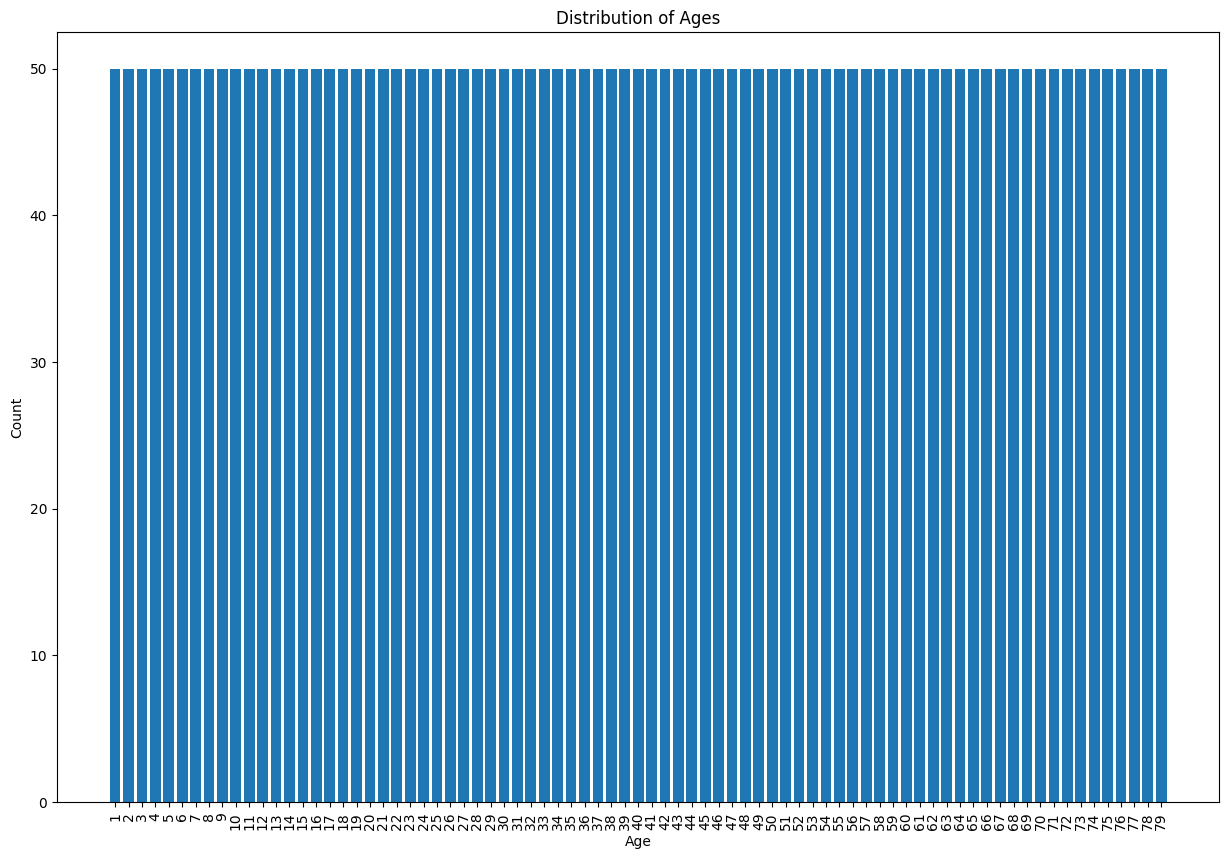

Maximum age: 79


In [10]:
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)


ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set the size of the figure
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate the x-axis labels by 90 degrees
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

max_age = max(map(int, x_ages))
print("Maximum age:", max_age)


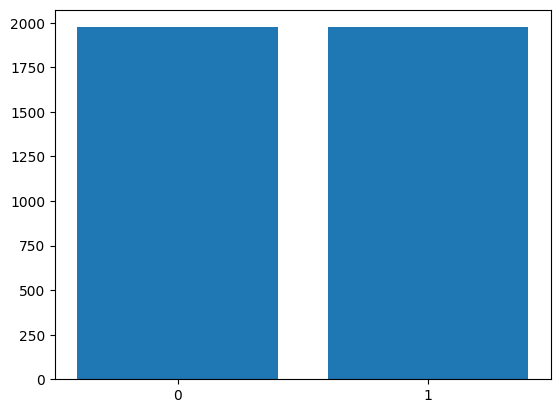

Max value: 1


In [11]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)

plt.show()
print("Max value:",max(genders))


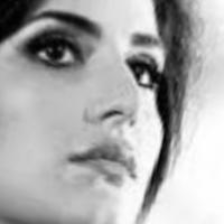

In [12]:
cv2_imshow(sorted_img[0])

In [13]:
id_img = 14
sample = sorted_img[id_img]

In [14]:
labels = np.zeros((len(ages), 2), dtype='float32') # 2 เพื่อเก็บค่าสองค่า แบบ labels[1,2]
features = np.zeros((len(ages),sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range (len(files)):
    labels[i,0] = int(ages[i])
    labels[i,1] = int(genders[i])
    features[i] = sorted_img[i]

In [15]:
print(labels.shape)
print(features.shape)

(3950, 2)
(3950, 224, 224, 1)


In [16]:
features = features / 255 #normalization

In [17]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = True)

In [18]:
for i in range (50):
    print(y_train[i])

[1. 1.]
[4. 1.]
[8. 0.]
[51.  0.]
[41.  1.]
[73.  1.]
[52.  1.]
[10.  0.]
[55.  1.]
[51.  1.]
[51.  1.]
[39.  1.]
[36.  0.]
[79.  1.]
[28.  1.]
[13.  1.]
[15.  0.]
[35.  1.]
[25.  1.]
[48.  1.]
[41.  0.]
[2. 0.]
[69.  1.]
[32.  1.]
[6. 1.]
[4. 0.]
[2. 1.]
[11.  1.]
[40.  1.]
[45.  1.]
[35.  1.]
[55.  1.]
[61.  0.]
[6. 1.]
[39.  1.]
[27.  0.]
[37.  1.]
[38.  0.]
[13.  1.]
[77.  1.]
[13.  1.]
[77.  0.]
[24.  0.]
[72.  1.]
[42.  1.]
[35.  1.]
[31.  1.]
[74.  0.]
[14.  1.]
[54.  1.]


In [19]:
print("Shape of the images:",sample.shape)
print("Training images numbers:",x_train.shape[0])
print("Testing images numbers:",x_test.shape[0])

Shape of the images: (224, 224, 1)
Training images numbers: 3160
Testing images numbers: 790


In [20]:
inputs = Input(shape=(224,224,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['mae','accuracy'])

In [21]:
history = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),
              epochs = 100, batch_size=80, shuffle = True)

Epoch 1/100
40/40 [==============================] - 47s 658ms/step - loss: 1096.2557 - dense_3_loss: 1095.1481 - dense_9_loss: 1.1076 - dense_3_mae: 26.9070 - dense_3_accuracy: 0.0142 - dense_9_mae: 0.4939 - dense_9_accuracy: 0.5142 - val_loss: 779.4298 - val_dense_3_loss: 778.7368 - val_dense_9_loss: 0.6930 - val_dense_3_mae: 23.1718 - val_dense_3_accuracy: 0.0051 - val_dense_9_mae: 0.4999 - val_dense_9_accuracy: 0.5076
Epoch 2/100
40/40 [==============================] - 20s 490ms/step - loss: 872.0779 - dense_3_loss: 871.3847 - dense_9_loss: 0.6934 - dense_3_mae: 24.1687 - dense_3_accuracy: 0.0142 - dense_9_mae: 0.4999 - dense_9_accuracy: 0.4987 - val_loss: 669.2770 - val_dense_3_loss: 668.5840 - val_dense_9_loss: 0.6930 - val_dense_3_mae: 21.4485 - val_dense_3_accuracy: 0.0051 - val_dense_9_mae: 0.4999 - val_dense_9_accuracy: 0.5076
Epoch 3/100
40/40 [==============================] - 20s 494ms/step - loss: 764.3368 - dense_3_loss: 763.6432 - dense_9_loss: 0.6935 - dense_3_mae: 22

In [22]:
model.save('combine_test.h')
history_test = history
print(history_test.history.keys())



dict_keys(['loss', 'dense_3_loss', 'dense_9_loss', 'dense_3_mae', 'dense_3_accuracy', 'dense_9_mae', 'dense_9_accuracy', 'val_loss', 'val_dense_3_loss', 'val_dense_9_loss', 'val_dense_3_mae', 'val_dense_3_accuracy', 'val_dense_9_mae', 'val_dense_9_accuracy'])


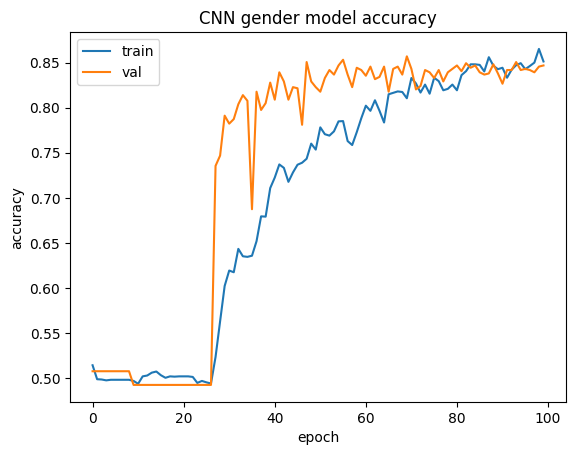

val accuracy: 73.82%


In [23]:
plt.plot(history_test.history['dense_9_accuracy'])
plt.plot(history_test.history['val_dense_9_accuracy'])
plt.title('CNN gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

val_acc = np.mean(history_test.history['val_dense_9_accuracy'])
print("%s: %.2f%%" % ('val accuracy',(val_acc*100)))

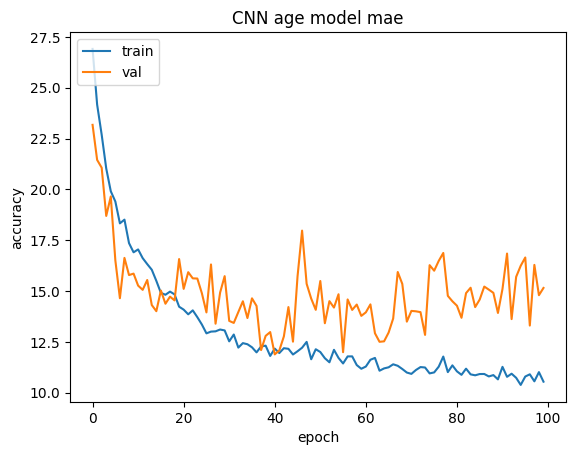

val mae: 14.89%


In [39]:
plt.plot(history_test.history['dense_3_mae'])
plt.plot(history_test.history['val_dense_3_mae'])
plt.title('CNN age model mae')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

val_mae = np.mean(history_test.history['val_dense_3_mae'])
print("%s: %.2f%%" %("val mae", val_mae))

In [25]:
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

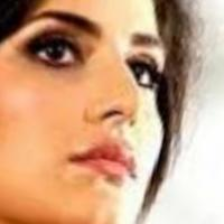

Actual Gender: Female Age: 36
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[23.958496]]


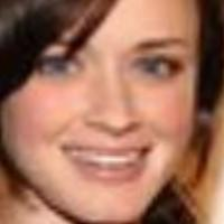

Actual Gender: Female Age: 24
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[19.83568]]


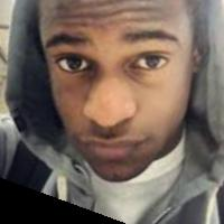

Actual Gender: Male Age: 21
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male Predicted Age: [[19.43192]]


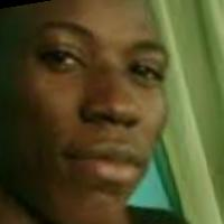

Actual Gender: Male Age: 29
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[24.188427]]


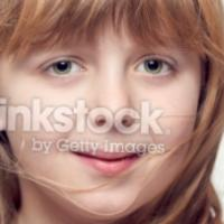

Actual Gender: Female Age: 10
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[15.4578705]]


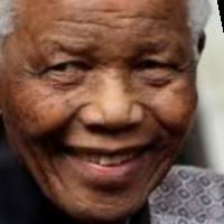

Actual Gender: Male Age: 54
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Male Predicted Age: [[39.049427]]


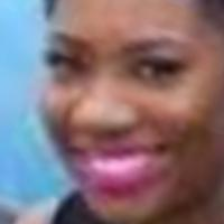

Actual Gender: Female Age: 42
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: [[33.0343]]


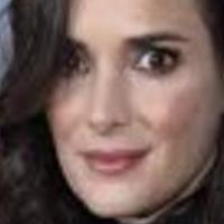

Actual Gender: Female Age: 35
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[26.717997]]


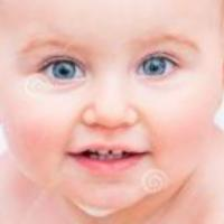

Actual Gender: Female Age: 1
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: [[12.68961]]


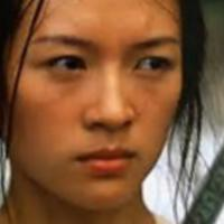

Actual Gender: Female Age: 22
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[18.211166]]


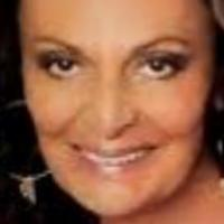

Actual Gender: Female Age: 47
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: [[34.434216]]


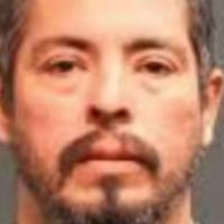

Actual Gender: Male Age: 42
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[28.905499]]


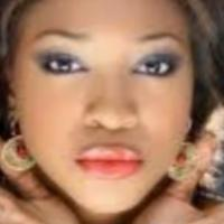

Actual Gender: Female Age: 18
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[17.75104]]


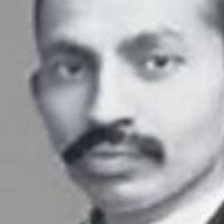

Actual Gender: Male Age: 27
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Male Predicted Age: [[22.766987]]


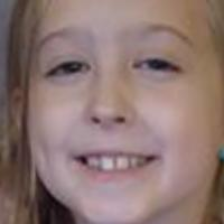

Actual Gender: Female Age: 8
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: [[14.404306]]


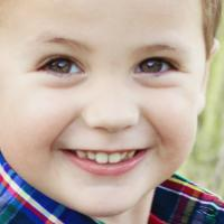

Actual Gender: Male Age: 4
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[12.518402]]


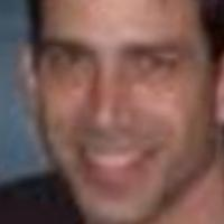

Actual Gender: Male Age: 34
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[29.265095]]


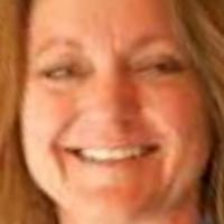

Actual Gender: Female Age: 52
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[40.244007]]


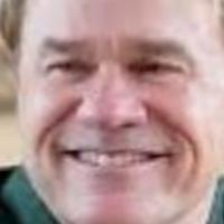

Actual Gender: Male Age: 70
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[60.915783]]


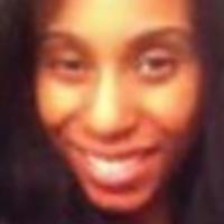

Actual Gender: Female Age: 30
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[23.921587]]


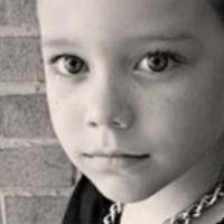

Actual Gender: Male Age: 7
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[13.393837]]


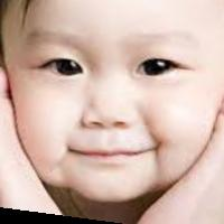

Actual Gender: Female Age: 2
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[12.092014]]


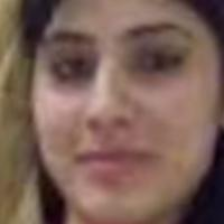

Actual Gender: Female Age: 29
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: [[22.130232]]


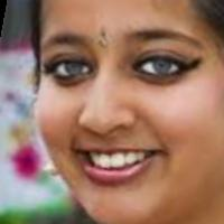

Actual Gender: Female Age: 26
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: [[21.674503]]


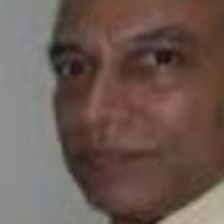

Actual Gender: Male Age: 64
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[40.507423]]


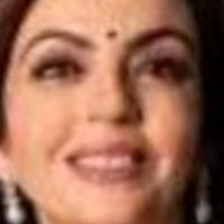

Actual Gender: Female Age: 32
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Female Predicted Age: [[25.965027]]


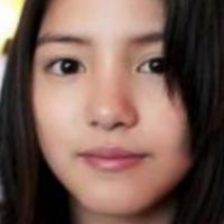

Actual Gender: Female Age: 15
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[13.962975]]


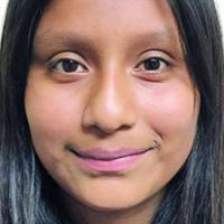

Actual Gender: Female Age: 17
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[12.706909]]


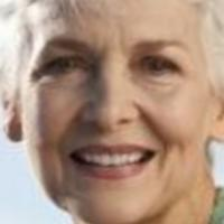

Actual Gender: Female Age: 74
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[56.983852]]


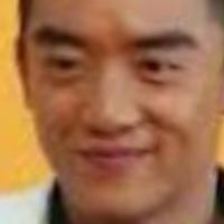

Actual Gender: Male Age: 29
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[20.027376]]


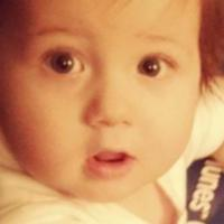

Actual Gender: Female Age: 1
1/1 [==============================] - 0s 24ms/step
Predicted Gender: Female Predicted Age: [[12.092014]]


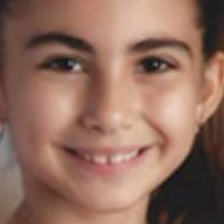

Actual Gender: Female Age: 12
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[12.092014]]


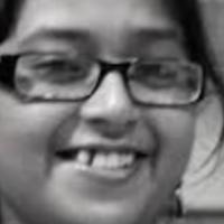

Actual Gender: Female Age: 22
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[24.487972]]


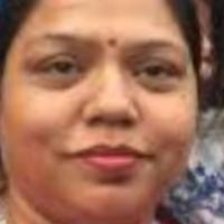

Actual Gender: Female Age: 35
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Female Predicted Age: [[24.801544]]


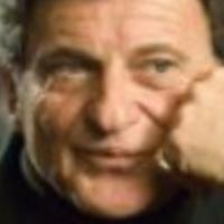

Actual Gender: Male Age: 55
1/1 [==============================] - 0s 24ms/step
Predicted Gender: Male Predicted Age: [[37.563442]]


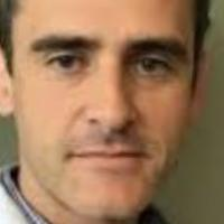

Actual Gender: Male Age: 42
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[30.581507]]


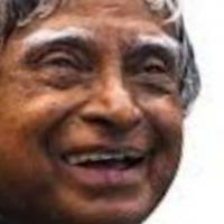

Actual Gender: Male Age: 65
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[37.150898]]


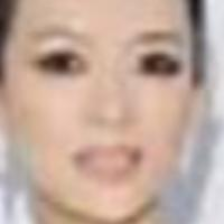

Actual Gender: Female Age: 26
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[26.151375]]


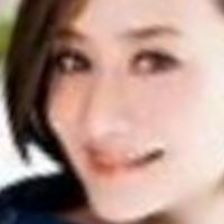

Actual Gender: Female Age: 30
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[28.27067]]


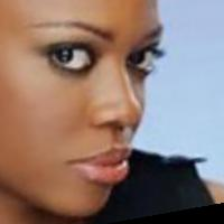

Actual Gender: Female Age: 26
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[18.160837]]


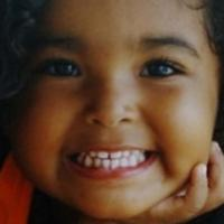

Actual Gender: Female Age: 3
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[15.509766]]


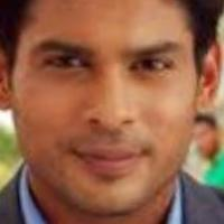

Actual Gender: Male Age: 26
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[19.154257]]


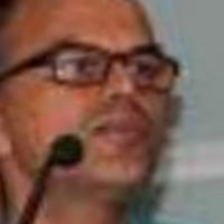

Actual Gender: Male Age: 34
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[26.346706]]


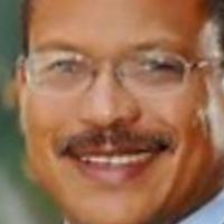

Actual Gender: Male Age: 58
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Male Predicted Age: [[45.513943]]


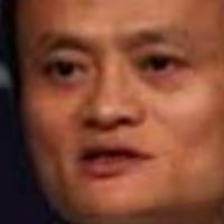

Actual Gender: Male Age: 55
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[31.052917]]


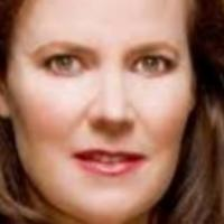

Actual Gender: Female Age: 36
1/1 [==============================] - 0s 29ms/step
Predicted Gender: Female Predicted Age: [[26.389915]]


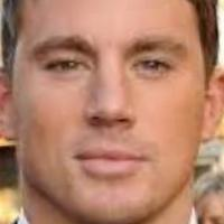

Actual Gender: Male Age: 29
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[37.044384]]


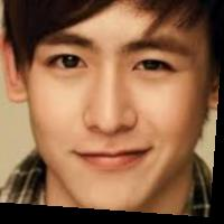

Actual Gender: Male Age: 20
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[16.511257]]


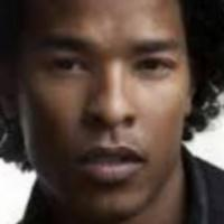

Actual Gender: Male Age: 26
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[22.08053]]


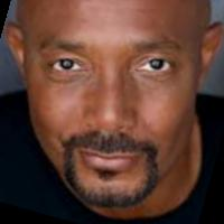

Actual Gender: Male Age: 36
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[28.300953]]


In [66]:
def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = val[0]
    gender = get_gender(val[1])
    print("Predicted Gender:",gender,"Predicted Age:",age)
for i in range (50): 
    indexes = [i]
    for idx in indexes:
        sample = sorted_img[idx]
        cv2_imshow(color_img[idx])
        print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
        res = get_result(sample)

In [ ]:
def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = val[0]
    gender = get_gender(val[1])
    print("Predicted Gender:",gender,"Predicted Age:",age)
for i in range (50): 
    indexes = [i]
    for idx in indexes:
        sample = sorted_img[idx]
        cv2_imshow(color_img[idx])
        print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
        res = get_result(sample)

In [69]:
predict = model.predict(x_test)

25/25 [==============================] - 3s 70ms/step


In [70]:
print(predict)

[array([[15.353601 ],
       [41.578415 ],
       [18.44656  ],
       [32.66427  ],
       [51.538727 ],
       [26.586046 ],
       [37.531494 ],
       [13.3847065],
       [33.197    ],
       [23.623043 ],
       [37.01278  ],
       [45.789696 ],
       [19.796358 ],
       [35.266605 ],
       [52.770447 ],
       [12.092014 ],
       [36.216293 ],
       [23.036678 ],
       [38.81387  ],
       [50.988045 ],
       [33.07883  ],
       [34.08842  ],
       [36.10915  ],
       [42.548782 ],
       [12.104656 ],
       [32.074844 ],
       [21.642315 ],
       [27.667648 ],
       [35.37035  ],
       [28.92338  ],
       [16.59984  ],
       [12.627935 ],
       [26.413013 ],
       [20.077297 ],
       [22.740398 ],
       [32.94725  ],
       [21.909836 ],
       [37.02189  ],
       [37.92807  ],
       [28.180876 ],
       [28.27067  ],
       [37.260853 ],
       [33.70059  ],
       [23.651056 ],
       [47.144077 ],
       [15.509768 ],
       [13.346338 ],
       [12.0

In [72]:
rmse = np.sqrt(mean_squared_error(y_test[:,0], predict[0]))
print("RMSE of age model: ", rmse)

RMSE of age model:  18.906025


In [28]:
import os
import zipfile
from google.colab import files

# Set the path to your source directory
src_dir = '/content/combine_test.h'

# Set the path to your destination zip file
dst_zip = '/content/2in1_CNN.zip'

# Create a zip file of the source directory
with zipfile.ZipFile(dst_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
  for root, dirs, files in os.walk(src_dir):
    for file in files:
      zipf.write(os.path.join(root, file))


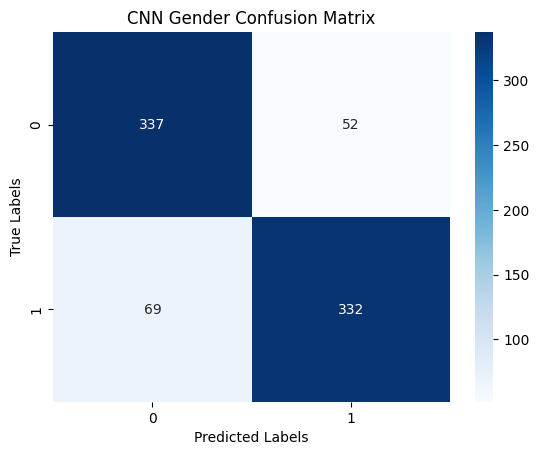

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_gender = np.round(predict[1]).flatten()

cm = confusion_matrix(y_test[:,1], y_pred_gender)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("CNN Gender Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [76]:
def error_count(error):
  error1 = 0
  error2 = 0
  error3 = 0
  error4 = 0
  if error < 5:
    error1 = error1+1
  elif error <= 10:
    error2 = error2+1
  elif error <= 15:
    error3 = error3+1
  elif error > 15:
    error4 = error4+1
  return error1,error2,error3,error4

In [82]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(len(x_test)):
    predicted_age = model.predict(np.expand_dims(x_test[i], axis=0))
    predicted_age = int(predicted_age[0])
    predicted_age_list.append(predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test[i][0]))/ int(max_age)) * 100
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4

print("Number of error less than 5%:", error1_total)
print("Number of error less than 10%:", error2_total)
print("Number of error equal or less than 15%:", error3_total)
print("Number of error more than 15%:", error4_total)


1/1 [==============================] - 0s 19ms/step
Number of error less than 5%: 115
Number of error less than 10%: 124
Number of error equal or less than 15%: 118
Number of error more than 15%: 433


In [84]:
percentage_error1 = (error1_total/len(x_test))*100
percentage_error2 = (error2_total/len(x_test))*100
percentage_error3 = (error3_total/len(x_test))*100
percentage_error4 = (error4_total/len(x_test))*100
print("Percentage of file that have 0-5 % error : ", round(percentage_error1,2), " %")
print("Percentage of file that have 6-10 % error: ", round(percentage_error2,2), " %")
print("Percentage of file that have 11-15 % error:", round(percentage_error3,2), " %")
print("Percentage of file that have more than 15% error : ", round(percentage_error4,2), " %")

Percentage of file that have 0-5 % error :  14.56  %
Percentage of file that have 6-10 % error:  15.7  %
Percentage of file that have 11-15 % error: 14.94  %
Percentage of file that have more than 15% error :  54.81  %


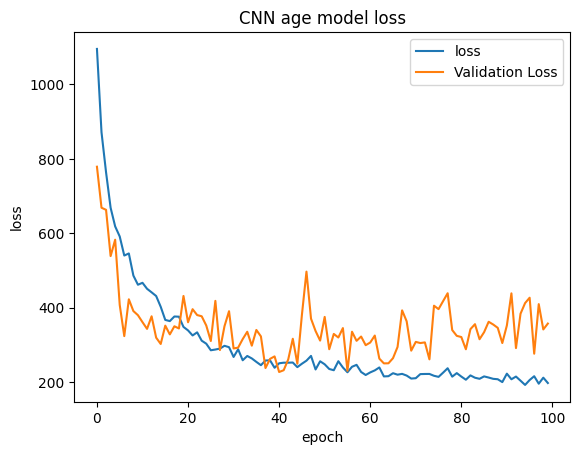

In [30]:
plt.plot(history_test.history['dense_3_loss'])
plt.plot(history_test.history['val_dense_3_loss'])
plt.title('CNN age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

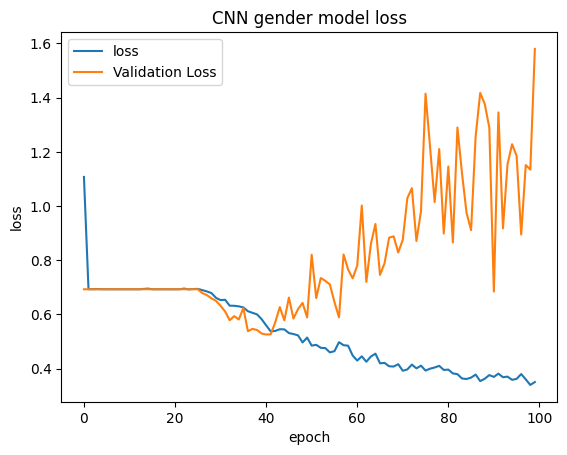

In [31]:
plt.plot(history_test.history['dense_9_loss'])
plt.plot(history_test.history['val_dense_9_loss'])
plt.title('CNN gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

In [86]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 220, 220, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

In [93]:
model_di = '/content/drive/MyDrive/2in1/combineCNN/combine_test.h'
meow = tf.keras.models.load_model(model_di)